## Bayesian Matrix Factorization

PIPATPAJONG Thapakorn SID : 1155184202

KHARUPONGSE Thien SID : 1155179480

### 1. Import dataset and cleaning

In [1]:
import pandas as pd
import numpy as np

In [2]:
# read the data
ratings = pd.read_csv("https://raw.githubusercontent.com/Lottotpk/dataset_estr2020/main/ratings.csv")
movies = pd.read_csv("https://raw.githubusercontent.com/Lottotpk/dataset_estr2020/main/movies.csv")
ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [3]:
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [4]:
# Reindex movieId
for i in range(len(ratings)):
  rIdx = movies.index[movies["movieId"] == ratings.loc[i, "movieId"]].tolist()[0]
  ratings.loc[i, "movieId"] = rIdx + 1

In [5]:
ratings

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,44,5.0,964983815
4,1,47,5.0,964982931
...,...,...,...,...
100831,610,9435,4.0,1493848402
100832,610,9462,5.0,1493850091
100833,610,9463,5.0,1494273047
100834,610,9464,5.0,1493846352


In [6]:
# check null
ratings.isnull().values.any()

False

In [7]:
# no rating = 0, we use 0 as null value for sparse ratings matrix
ratings[ratings["rating"] == 0]

,userId,movieId,rating,timestamp


In [8]:
# create the ratings matrix, denoted as R
nUsers = max(ratings["userId"]) # or ratings["userId"].nunique()
nMovies = max(ratings["movieId"])
R = np.zeros((nUsers, nMovies))
R.shape

(610, 9742)

### 2. Split the data into training and testing set

Training and testing set must contain every user

In [9]:
ratings

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,44,5.0,964983815
4,1,47,5.0,964982931
...,...,...,...,...
100831,610,9435,4.0,1493848402
100832,610,9462,5.0,1493850091
100833,610,9463,5.0,1494273047
100834,610,9464,5.0,1493846352


In [10]:
n = len(ratings)
perm = np.random.permutation(n)
trainIdx = perm[ : (n*7) // 10]
testIdx = perm[(n*7) // 10: ]

rangeUser = {}
lastId = 1
start = 0
for i in range(len(ratings)):
    if ratings.loc[i, "userId"] != lastId or i == len(ratings) - 1:
        rangeUser[lastId] = [start, i-1]
        start = i
        lastId += 1

# From the dataset, we use 70% of the data for training, and 30% for testing
trainIdx = []
testIdx = []
for i in range(1, len(rangeUser)+1):
    start = rangeUser[i][0]
    end = rangeUser[i][1]
    jump = ((end-start)*7) // 10 + 1
    trainIdx += [a for a in range(start, start + jump)]
    testIdx += [a for a in range(start + jump, end + 1)]

In [11]:
# R[i, j] = rating from userId i+1 on movieId j+1, 0 means null value
for k in trainIdx:
  i = ratings.loc[k, "userId"] - 1
  j = ratings.loc[k, "movieId"] - 1
  R[i, j] = ratings.loc[k, "rating"]

### 3. Set up some functions which will be used later

In [12]:
import math
def dnorm(x, mean, var):
  const = 1 / math.sqrt(2 * math.pi * var)
  expo = math.exp(-((x - mean) ** 2) / (2 * var))
  return const*expo

def pdfR(r_ab, ua, vb, var):
  return dnorm(r_ab, sigmoid(ua, vb), var)

Gibbs Sampling algorithm

In [13]:
# Gibbs Sampling: sample U, V
# Note: K << min(N, M), var = hyperparameter
def Gibbs(R, K, var, itr):
  U = np.zeros((nUsers, K, itr))
  V = np.zeros((nMovies, K, itr))
  U[:, :, 0] = np.random.normal(0, 1, size = (nUsers, K))
  V[:, :, 0] = np.random.normal(0, 1, size = (nMovies, K))

  for t in range(1, itr):
    if t % 100 == 0:
      print(t)
    for i in range(len(U)):
      sum_vj = np.zeros((K, K))
      sum_vjr = np.zeros(K)
      for j in range(len(V)):
        if R[i, j] != 0:
          sum_vj += np.matmul(np.transpose(np.array(V[j, :, t-1], ndmin = 2)), np.array(V[j, :, t-1], ndmin = 2))
          sum_vjr += R[i, j] * V[j, :, t-1]
      var_u = np.identity(K) + var * sum_vj
      var_u_inv = np.linalg.inv(var_u)
      mu_u = var * sum_vjr
      mu_u = np.matmul(mu_u, var_u_inv)
      U[i, :, t] = np.random.multivariate_normal(mu_u, var_u_inv)

    for j in range(len(V)):
      sum_ui = np.zeros((K, K))
      sum_uir = np.zeros(K)
      for i in range(len(U)):
        if R[i, j] != 0:
          sum_ui += np.matmul(np.transpose(np.array(U[i, :, t], ndmin = 2)), np.array(U[i, :, t], ndmin = 2))
          sum_uir += R[i, j] * U[i, :, t]
      var_v = np.identity(K) + var * sum_ui
      var_v_inv = np.linalg.inv(var_v)
      mu_v = var * sum_uir
      mu_v = np.matmul(mu_v, var_v_inv)
      V[j, :, t] = np.random.multivariate_normal(mu_v, var_v_inv)
  return U, V

### 4. Run the algorithm by varying the number of hidden features (K) in the matrix U and V

In [17]:
# Main function
# Compare with different values of K
K_list = [a * 5 for a in range(5, 0, -1)]
err_list = []
for K in K_list:
    print(K, "-----------")
    itr = 1000
    var = 2
    U, V = Gibbs(R, K, var, itr)
    
    T = (8*itr) // 10 + 1
    U = U[:, :, T:itr+1]
    V = V[:, :, T:itr+1]
    true_val = []
    estimated_val = []
    for k in testIdx:
        i = ratings.loc[k, "userId"] - 1
        j = ratings.loc[k, "movieId"] - 1
        true_val.append(ratings.loc[k, "rating"])

        rating_list = [a/2 for a in range(11)]
        # rating_list = [a/10 for a in range(11)]
        max_prob = 0
        maxIdx = -1
        for m in range(len(rating_list)):
            pr = 0
            for t in range(itr-T):
                # pr += pdfR(rating_list[m], U[i, :, t], V[j, :, t], 1)
                pr += dnorm(rating_list[m], np.matmul(U[i, :, t], np.transpose(V[j, :, t])), 1)
            if pr/(itr-T) > max_prob:
                max_prob = pr/(itr-T)
                maxIdx = m
        # estimated_val.append(rating_list[maxIdx] * 5)
        estimated_val.append(rating_list[maxIdx])

    error = 0
    for i in range(len(true_val)):
        error += (true_val[i] - estimated_val[i]) ** 2
    error = error / len(true_val)
    error = math.sqrt(error)
    err_list.append(error)

25 -----------
100
200
300
400
500
600
700
800
900
20 -----------
100
200
300
400
500
600
700
800
900
15 -----------
100
200
300
400
500
600
700
800
900
10 -----------
100
200
300
400
500
600
700
800
900
5 -----------
100
200
300
400
500
600
700
800
900


### 5. Plotting the relationship between root mean squared error (RMSE) and number of hidden features (K)

In [18]:
rounded_err = []
for n in err_list:
    rounded_err.append(round(n, 3))
rounded_err

[1.119, 1.113, 1.115, 1.115, 1.121]

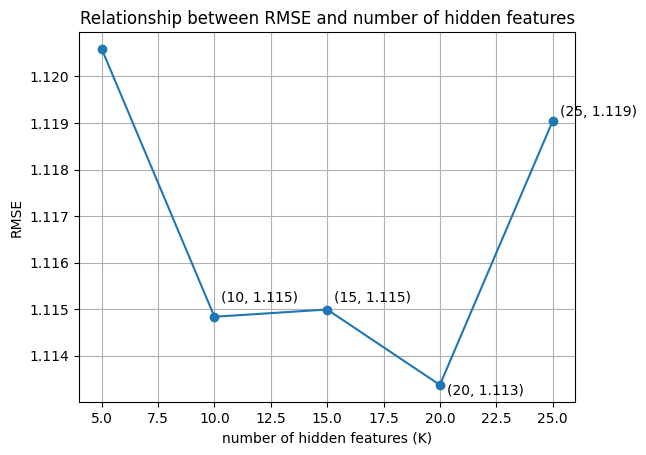

In [36]:
import matplotlib.pyplot as plt
plt.plot(K_list, err_list, marker = "o")
plt.xlabel("number of hidden features (K)")
plt.ylabel("RMSE")
plt.title("Relationship between RMSE and number of hidden features")
for i, (xi, yi) in enumerate(zip(K_list, rounded_err)):
    plt.annotate(f"({xi}, {yi})", (xi, yi), textcoords = "offset points", xytext = (5, 5))
plt.grid(True)
plt.show()

## Other prediction models

In [20]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier

In [21]:
# Change rating into discrete values
df = ratings.copy()
df["rating"] *= 2
df = df.astype({"rating" : "int"})

In [22]:
features = df[["userId", "movieId"]].values
labels = df[["rating"]].values
train, test, train_labels, test_labels = train_test_split(features, labels, test_size = 0.3, random_state = 123)

In [23]:
model = ["Logistic", "SVC", "KNN", "Random Forest"]
RMSE_model = []

### Logistic regression model

In [24]:
logis = LogisticRegression(solver = "newton-cg")
logis.fit(train, train_labels)
Y_pred = logis.predict(test)

C:\Users\lotto\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [25]:
# RMSE
import math
error = 0
for i in range(len(Y_pred)):
  error += ((Y_pred[i] - test_labels[i, 0])/2) ** 2
error /= len(Y_pred)
error = math.sqrt(error)
RMSE_model.append(error)
error

1.1615414497780143

### Support vector machines classification

In [26]:
svc = SVC()
svc.fit(train, train_labels)
Y_pred = svc.predict(test)

C:\Users\lotto\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [27]:
import math
error = 0
for i in range(len(Y_pred)):
  error += ((Y_pred[i] - test_labels[i, 0])/2) ** 2
error /= len(Y_pred)
error = math.sqrt(error)
RMSE_model.append(error)
error

1.1643555203314648

Computationally heavy: 9 minutes to compute

### K Nearest neighbors classifier

In [28]:
knn = KNeighborsClassifier(n_neighbors = 20)
knn.fit(train, train_labels)
Y_pred = knn.predict(test)

C:\Users\lotto\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neighbors\_classification.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


In [29]:
import math
error = 0
for i in range(len(Y_pred)):
  error += ((Y_pred[i] - test_labels[i, 0])/2) ** 2
error /= len(Y_pred)
error = math.sqrt(error)
RMSE_model.append(error)
error

1.1806827551065568

### Random forest

In [30]:
rf = RandomForestClassifier(n_estimators = 20)
rf.fit(train, train_labels)
Y_pred = rf.predict(test)

C:\Users\lotto\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


In [31]:
import math
error = 0
for i in range(len(Y_pred)):
  error += ((Y_pred[i] - test_labels[i, 0])/2) ** 2
error /= len(Y_pred)
error = math.sqrt(error)
RMSE_model.append(error)
error

1.2531702550238044

### 6. Comparing the Bayesian Matrix Factorization against other prediction models

In [32]:
model.append("BMF")
RMSE_model.append(min(err_list))

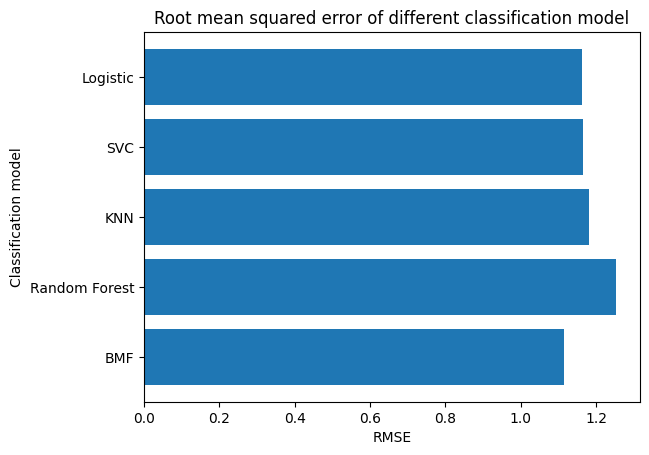

In [33]:
fig, ax = plt.subplots()
ax.barh(model, RMSE_model)
ax.invert_yaxis()
ax.set_xlabel("RMSE")
ax.set_ylabel("Classification model")
ax.set_title("Root mean squared error of different classification model")
plt.show()